# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [117]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = 'data/train.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [121]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = X_train.shape[0]

# TODO: number of testing examples
n_test = X_test.shape[0]

# TODO: what's the shape of an image?
image_shape = X_train.shape[1:-1]

# TODO: how many classes are in the dataset
n_classes = max(y_train)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 42


Keys in train dataset:
 - sizes: (39209, 2)
 - features: (39209, 32, 32, 3)
 - coords: (39209, 4)
 - labels: (39209,)
30000 features to be displayed as a 50x60.0 matrix


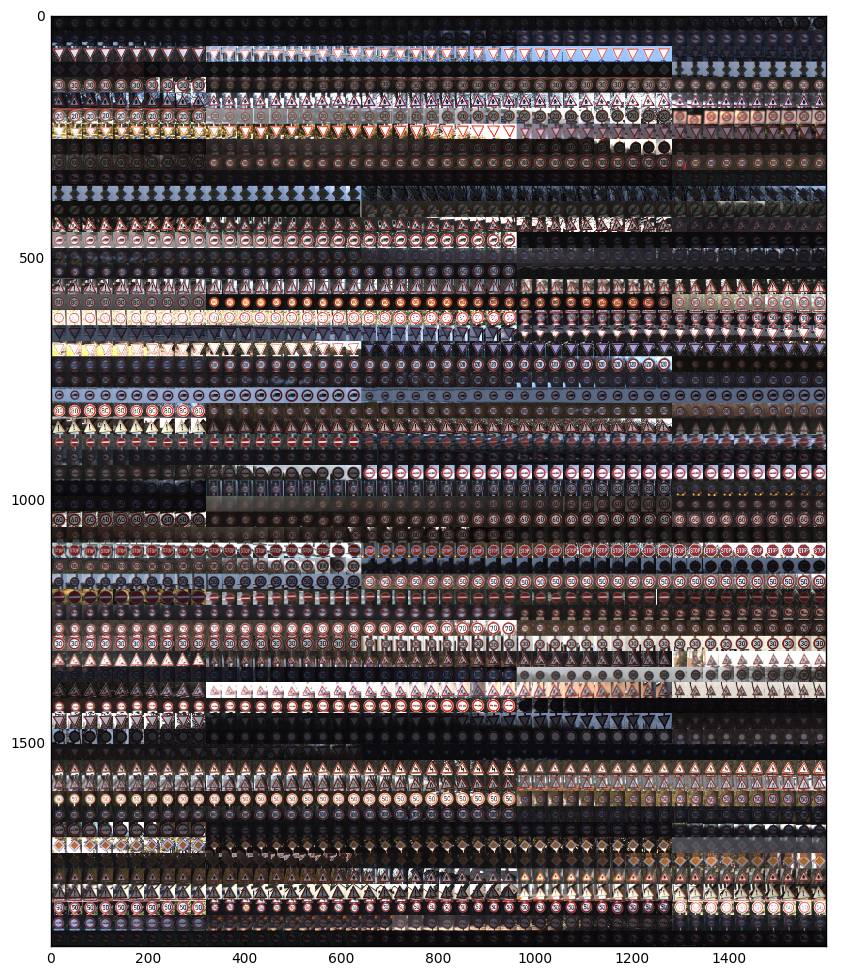

In [123]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

import math
import random
import numpy as np
from matplotlib.pyplot import imshow
from matplotlib.pyplot import figure
from matplotlib.pyplot import rcParams

print('Keys in train dataset:')
for key, val in train.items():
    print(' - {}: {}'.format(key, val.shape))

%matplotlib inline
rcParams['figure.figsize'] = (12.0, 12.0)

width = 50
height = 600
sample = 0.1
features = train['features'][:width*height]
count = features.shape[0]

print(
    '{} features to be displayed as a {}x{} matrix'.format(
        count, width, sample * height))

rows = np.array_split(features, height)
img_rows =list()
for row in rows:
    img_rows.append(np.concatenate(row, axis=1))
img_rows = random.sample(img_rows, int(sample * height))
img_matrix = np.concatenate(img_rows, axis=0)

imshow(img_matrix)


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [213]:
### Preprocess the data here.
# Functions extracted from Finding Lane Lines on the Road
# To be used to mask the region of interest and convert the images to grayscale

import numpy as np
import cv2
from matplotlib.pyplot import imshow
from matplotlib.pyplot import figure
from matplotlib.pyplot import rcParams

def eq_grayscale(img):
    """Applies the Grayscale and Histogram equalization transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.equalizeHist(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

print('Helper functions defined and libraries imported.')

Helper functions defined and libraries imported.


In [214]:
# Defining preprocess pipeline

def preprocess(img, coords):
    """Converts to greyscale and masks around region of interest."""
    vertices = np.array([[coords[:2],
                          ([coords[0], coords[2]]),
                          coords[2:],
                          ([coords[3], coords[1]])]],
                        dtype=np.int32)
    return region_of_interest(grayscale(img), vertices)
    

Preprocessing image 20436 of type 13:
Region of interest: [ 5  6 35 40]


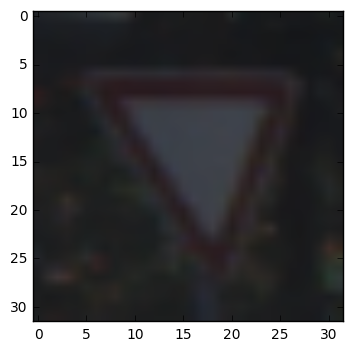

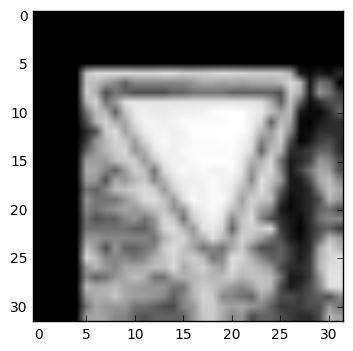

In [215]:
# Test on an ramdomly selected image
%matplotlib inline
from random import randint
img_ind = randint(0, n_train)
print('Preprocessing image {} of type {}:'.format(img_ind, y_train[img_ind]))
orig_img = X_train[img_ind]
coords = train['coords'][img_ind]
print('Region of interest: {}'.format(coords))
figure()
imshow(orig_img)
processed_img = preprocess(orig_img, coords)
figure()
imshow(processed_img, cmap='gray')


### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

The Preprocessing pipeline works in three steps:

1. The image is converted to Greyscale. This removes the colour variability due to changes in lighting conditions and should not affect the recognition of the signs since their meaning is also encoded in their shape.
2. Its contrast is equalized. This is similar to normalization but works image-by-image. Since the colour white is present in all signs, it is safe to assume this will effectively normalize the images, improve their contrast and make them overall more similar.
3. Masking the region outside of the sign. This prevents the NN to need to learn unnecessary features from the background.

In [2]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

In [6]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [5]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [3]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [4]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.